# Pyro Crash Course – Notebook 4: Latent Variables and Posterior Inference

This notebook introduces **latent random variables** into our sensor calibration model — enabling a **fully Bayesian** approach with **posterior uncertainty**.

### 🔙 Quick Recap

*Notebook 3* used deterministic trainable parameters (`alpha_0`, `alpha_1`) for bias and scale.  
It could **fit a line**, but gave **no uncertainty** on the estimated parameters.

Today we upgrade the model to treat those parameters as **latent variables**, equipped with **Gaussian priors** and inferred using **variational approximation**.

---

### 🎯 Learning Goals

- Replace `pyro.param` with **latent samples** from a prior using `pyro.sample`
- Introduce a **nontrivial guide** (variational posterior) and learn its parameters
- Understand the ELBO when latent variables are present:  
  $$\mathrm{ELBO} = \mathbb{E}_{q(z)}[\log p(x,z) - \log q(z)]$$
- Compare:
  - Prior Predictive Distribution
  - Posterior Distribution
  - Posterior Predictive Distribution
- Validate inference quality against **closed-form Bayesian update**

---

For this, do the following:
   1. Imports and definitions  
   2. Build model and guide  
   3. Perform inference  
   4. Interpretations and illustrations


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_4_model_2.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 Next: `pyro_cc_5_model_3` replaces the two unobserved latents by a hierarchy of latents


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


---

# Start of Notebook 4

## 1. Imports and definitions

We import:

- `pandas` to read the dataset generated in the previous notebook
- `pyro` and `torch` to build the model and run inference
- `matplotlib` for plotting

We also **infer the shape** of the dataset (`n_device`, `n_measure`) and load the tensors for true and measured temperatures.

📌 This is the first notebook that **introduces latent variables into the model**.


In [13]:
"""
    1. Imports and definitions
"""

# i) Imports
# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl

import pyro
import torch
import pandas
import copy
import matplotlib.pyplot as plt

# ii) Definitions
# Read csv, infer dimensions
# !wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


---

## 2. Build Model and Guide

We now move from deterministic parameters to **latent random variables**.  
This is our first *fully Bayesian* model in the series.

### 🧱 Model Structure

We assume each thermistor produces measurements according to:

$$
T_{\text{measured}} = \alpha_0 + \alpha_1 \cdot T_{\text{true}} + \text{Noise},
$$

where:

- $\alpha_0 \sim \mathcal{N}(0, 0.1)$ is an unknown offset
- $\alpha_1 \sim \mathcal{N}(1, 0.1)$ is an unknown scale
- $\text{Noise} \sim \mathcal{N}(0, \sigma)$ is i.i.d. Gaussian noise with known $\sigma = 0.3$

Both $\alpha_0$ and $\alpha_1$ are **latent** – we assume prior knowledge but no direct observation. We will often use the symbol $z$ as representative for the latents, i.e. $z = (\alpha_0, \alpha_1)$ as $z$ is the standard notation to designate latents.

This change allows:

- Injection of prior knowledge (e.g. from spec sheets or calibration)
- Estimation of **posterior distributions** over model parameters
- Quantification of uncertainty through **posterior variance**


In [14]:
"""
    2. Build model and guide
"""

# i) Define the model

# Define priors
mu_alpha_0 = 0
mu_alpha_1 = 1
sigma_alpha_0 = 0.1
sigma_alpha_1 = 0.1

# Build the model in pyro
def model(input_vars = T_true, observations = None):
    # We dont need pyro.param anymore but instead we sample offset and scale from
    # the prior distributions. This will declare them as random and require us
    # to specify a variational distribution later in the guide.
    alpha_0_prior = pyro.distributions.Normal(mu_alpha_0, sigma_alpha_0)
    alpha_0 = pyro.sample('alpha_0', alpha_0_prior)
    alpha_1_prior = pyro.distributions.Normal(mu_alpha_1, sigma_alpha_1)
    alpha_1 = pyro.sample('alpha_1', alpha_1_prior)
    
    # Build the observation distribution using the sampled alpha_0 and alpha_1.
    obs_dist = pyro.distributions.Normal(loc = alpha_0 + alpha_1 * T_true,
                                         scale = sigma_T_meas)
    
    # Sample from this distribution and declare the samples independent in the
    # first two dims. Independence here means that sampling the noise is done 
    # independently of device or T_true. It does not mean that there are independent
    # alpha_0, alpha_1 for each device and measurement..
    with pyro.plate('device_plate', dim = -2):
        with pyro.plate('measure_plate', dim = -1):
            obs = pyro.sample('observations', obs_dist, obs = observations)
    
    return obs


---

### 🤖 Guide: Inference Model

To infer the unobserved values of $\alpha_0, \alpha_1$, we define a **guide**, i.e. a *variational approximation* to the posterior:

$$
q_\phi(\alpha_0, \alpha_1) \approx p(\alpha_0, \alpha_1 \mid \text{data})
$$

We choose:

- Independent Normal distributions
- Trainable parameters $\mu_{\phi}, \sigma_{\phi}$
- Positivity constraints on the standard deviations

This is the **first time in the course** where the guide contains learnable parameters.

---

### 🧠 Modeling Insight

Swapping deterministic values for latent variables moves us into Bayesian territory.  
In contrast to `model_1`, where we fit best-point estimates (via MLE), we now:

- Infer *distributions* over $\alpha_0$, $\alpha_1$
- Capture uncertainty in those values
- Enable sampling-based predictions with uncertainty bands

While we shouldn't expect a performance boost (we're not modeling the structure any better), we now gain **epistemic uncertainty** over our parameters.

In [15]:
# ii) Build the guide
def guide(input_vars = T_true, observations = None):
    # We will approximate the posterior distributions of alpha_0, alpha_1 by
    # Normal distributions with unknown means and standard deviations.
    alpha_0_mu_post = pyro.param('alpha_0_mu_post', init_tensor = torch.zeros([]))
    alpha_1_mu_post = pyro.param('alpha_1_mu_post', init_tensor = torch.ones([]))
    
    alpha_0_sigma_post = pyro.param('alpha_0_sigma_post', init_tensor = torch.ones([]),
                                    constraint = pyro.distributions.constraints.positive)
    alpha_1_sigma_post = pyro.param('alpha_1_sigma_post', init_tensor = torch.ones([]),
                                    constraint = pyro.distributions.constraints.positive)

    # In the guide we need to sample the unobserved latents to declare the model
    # for their posteriors. 
    alpha_0_dist_post = pyro.distributions.Normal(loc = alpha_0_mu_post,
                                                  scale = alpha_0_sigma_post)
    alpha_1_dist_post = pyro.distributions.Normal(loc = alpha_1_mu_post,
                                                  scale = alpha_1_sigma_post)

    alpha_0 = pyro.sample('alpha_0', alpha_0_dist_post)
    alpha_1 = pyro.sample('alpha_1', alpha_1_dist_post)

    return alpha_0, alpha_1


---

### Illustration of model and guide

To better visualize the beliefs of our model on which data are likely and how the latent variables are distributed, we can showcase again the graphical models. Note how the visual representation includes ellipses for $\alpha_0, \alpha_1$ because these are not simple parameters anymore. This time, also the guide is nontrivial.


In [16]:
# iii) Illustrate model and guide
graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
graphical_guide = pyro.render_model(model = guide, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
    

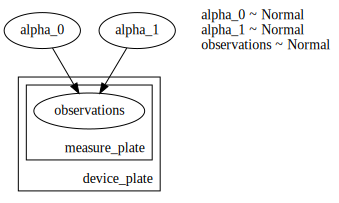

In [17]:
graphical_model

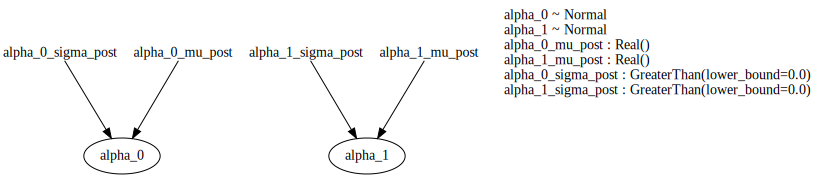

In [18]:
graphical_guide

We can also plot the output of sampling from prior-predictive, posterior, and posterior-predictive distributions.

| Symbol | Definition | Pyro call |
|--------|------------|-----------|
| **Prior-predictive**  $p_\theta(x,z)$ | Draw latents $z$ from the prior, then simulate data $x$ from the likelihood | `Predictive(model)` |
| **Posterior**  $q_\phi(z)\!\approx\!p_\theta(z\mid x)$ | Variational approximation to true posterior | `Predictive(guide)` |
| **Posterior-predictive**  $p_\theta(x' \mid x)$ | Draw $z\!\sim\!q_\phi$ and simulate new data $x'$ | `Predictive(model, guide=guide)` |

Mathematically:

$$
\begin{aligned}
p_\theta(x,z) &= p_\theta(z)\,p_\theta(x\mid z),\\[4pt]
q_\phi(z) &\approx p_\theta(z\mid x),\\[4pt]
p_\theta(x' \mid x) &= \int p_\theta(x' \mid z)\,q_\phi(z)\,dz.
\end{aligned}
$$

Sampling each of these gives us intuition about **what the model believes** before and after observing the data. We will plot these results later in section 4.


In [19]:
# iv) Record example outputs of model and guide prior to training
n_model_samples = 30
n_guide_samples = 1000  

predictive = pyro.infer.Predictive
prior_predictive_pretrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_pretrain_dict = predictive(guide, num_samples = n_guide_samples)()
posterior_pretrain = torch.vstack((posterior_pretrain_dict['alpha_0'],
                                   posterior_pretrain_dict['alpha_1'])).T
posterior_predictive_pretrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


---

## 3. Perform Inference

We use **Stochastic Variational Inference** (SVI) to optimize the guide parameters.

This involves:

1. Sampling latents $z$ from the guide  
2. Plugging sampled latents $z$ into the model  
3. Estimating the ELBO  
4. Taking gradients and updating parameters

We increase `num_particles` to 5 to reduce variance in the Monte Carlo ELBO estimate.

---

### 🔬 ELBO with Latent Variables

The Evidence Lower Bound (ELBO) becomes more complex in this model:

$$
\text{ELBO}(\theta, \phi) = 
\underbrace{\mathbb{E}_{q_\phi}[\log p_\theta(x, z)]}_{\text{joint likelihood}} - 
\underbrace{\mathbb{E}_{q_\phi}[\log q_\phi(z)]}_{\text{posterior entropy}}
$$

Or, in the equivalent KL-divergence form:

$$
\text{ELBO} = 
- \log p_\theta(x) + 
\text{KL}\big(q_\phi(z) \;||\; p_\theta(z \mid x)\big)
$$

🧠 Key Observations:

- **We cannot compute $\log p_\theta(x)$** directly – we estimate it via samples.
- The **KL divergence** no longer vanishes (as it did in previous models).
- ELBO becomes a **stochastic objective**, with noise coming from both latent and noise sampling.

---

### 📉 Consequences for Training

- The ELBO curve will be **noisy**
- You can't directly compare ELBO values across models anymore
- The ELBO is now *strictly above* the negative log-likelihood, due to the KL term

Despite these challenges, this shift to **variational Bayesian inference** allows more flexible modeling and better uncertainty quantification.



In [20]:
"""
    3. Perform inference
"""

# i) Set up inference
adam = pyro.optim.Adam({"lr": 1.0})
elbo = pyro.infer.Trace_ELBO(num_particles = 5)
svi = pyro.infer.SVI(model, guide, adam, elbo)

# ii) Perform svi
data = (T_true, T_meas)
loss_sequence = []
for step in range(1000):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %50 == 0:
        print(f'epoch: {step} ; loss : {loss}')        

# iii) Record example outputs of model and guide after training
prior_predictive_posttrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_posttrain_dict = predictive(guide, num_samples = n_guide_samples)()
posterior_posttrain = torch.vstack((posterior_posttrain_dict['alpha_0'],
                                   posterior_posttrain_dict['alpha_1'])).T
posterior_predictive_posttrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


# iv) Additional investigations
# We now inspect the model and guide using pyros inbuilt functionality. This allows
# us insight into interior details of model and guide; but we only plot the shapes.
model_trace = pyro.poutine.trace(model).get_trace(T_true, observations = T_meas)
guide_trace = pyro.poutine.trace(guide).get_trace(T_true, observations = T_meas)
print('These are the shapes inside of the model : \n {}'.format(model_trace.format_shapes()))
print('These are the shapes inside of the guide : \n {}'.format(guide_trace.format_shapes()))

# The parameters of the posterior are again stored in pyro's param_store
for name, value in pyro.get_param_store().items():
    print('Param : {}; Value : {}'.format(name, value))
   
# Note: the log_prob values are also accessible by inspection of the model trace.
# But now they do not exactly correspond to the ELBO.
model_trace.compute_log_prob()
log_prob_from_trace = torch.sum(model_trace.nodes["observations"]["log_prob"])


epoch: 0 ; loss : 126926.10657963195
epoch: 50 ; loss : 7982.397171359407
epoch: 100 ; loss : 6484.323213414182
epoch: 150 ; loss : 6475.252176068365
epoch: 200 ; loss : 6475.063584488356
epoch: 250 ; loss : 6476.082784408116
epoch: 300 ; loss : 6474.509098242304
epoch: 350 ; loss : 6475.397339012727
epoch: 400 ; loss : 6474.423915224456
epoch: 450 ; loss : 6475.086143572321
epoch: 500 ; loss : 6473.919034794276
epoch: 550 ; loss : 6476.746348305283
epoch: 600 ; loss : 6474.766491886881
epoch: 650 ; loss : 6475.469972749293
epoch: 700 ; loss : 6474.8361942135325
epoch: 750 ; loss : 6474.687735219071
epoch: 800 ; loss : 6477.487205869005
epoch: 850 ; loss : 6474.8755139192945
epoch: 900 ; loss : 6474.990367053557
epoch: 950 ; loss : 6474.786840389344
These are the shapes inside of the model : 
     Trace Shapes:        
     Param Sites:        
    Sample Sites:        
     alpha_0 dist       |
            value       |
     alpha_1 dist       |
            value       |
observations 

---

### 🧮 Closed-Form Posterior Comparison

For this model, we can derive the true posterior analytically.

We compute:

- The **posterior mean and covariance** from conditioning a multivariate Gaussian
- The result is exact under the model assumptions

Then we compare:

- Posterior means from Pyro (via `pyro.param`)
- Posterior means from the closed-form solution

✅ The means match well  
⚠️ The variances from SVI are **underestimated**

> This is a known issue with **mean-field variational inference**, which cannot capture posterior correlations.  
See *Blei et al., "Variational Inference: A Review for Statisticians"*, page 9.


In [21]:
# We compute the closed form solution for this problem by deriving the posterior
A = torch.vstack((torch.ones([n_device*n_measure]), T_true.flatten())).T
mu_alpha = torch.tensor([mu_alpha_0, mu_alpha_1], dtype = torch.float64)
Sigma_alpha = torch.tensor([[sigma_alpha_0**2, 0], [0, sigma_alpha_1**2]], dtype = torch.float64)
Sigma_noise = (sigma_T_meas**2)*torch.eye(n_device*n_measure)
Sigma_y = A@Sigma_alpha@A.T + Sigma_noise

mu_alpha_cf = mu_alpha + Sigma_alpha @ A.T@torch.linalg.pinv((A@Sigma_alpha@A.T
                        +  Sigma_noise)) @(T_meas.flatten() - T_true.flatten())
Sigma_alpha_cf = Sigma_alpha - Sigma_alpha @ A.T@torch.linalg.pinv((A@Sigma_alpha@A.T
                        + Sigma_noise)) @A@Sigma_alpha

print('The closed form solution is \n alpha_0_mu_post = {}, alpha_0_sigma_post = {};\n'
      'alpha_1_mu_post = {}, alpha_1_sigma_post = {};\n'
      .format(mu_alpha_cf[0], torch.sqrt(Sigma_alpha_cf[0,0]), 
              mu_alpha_cf[1], torch.sqrt(Sigma_alpha_cf[1,1])))


The closed form solution is 
 alpha_0_mu_post = 0.4558351333067122, alpha_0_sigma_post = 0.05747812455681187;
alpha_1_mu_post = 1.0055272626530218, alpha_1_sigma_post = 0.0037950257800353046;



---

## 4. Interpretations and Illustrations

### 📉 ELBO Loss During Training

We visualize the ELBO during optimization:

- The loss is **noisy** due to stochastic sampling of latent variables and ELBO estimation
- We plot it on a **log scale** to highlight multiplicative improvement

This curve shows how inference gradually improves our approximation of the true posterior. We do **not** expect a perfectly smooth descent.



### 📊 Predictive and Posterior Visualizations

We now compare the following distributions before and after training:

| Distribution Type               | Description                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| **Prior predictive**             | Model with $\alpha_0, \alpha_1$ sampled from priors                         |
| **Posterior predictive**         | Model conditioned on latent samples from the guide                         |
| **Guide posterior (2D histogram)**| Samples from $q_\phi(\alpha_0, \alpha_1)$                                  |

We plot:

1. Measurement data
2. Samples from the prior predictive
3. Samples from the posterior predictive
4. The learned posterior over $(\alpha_0, \alpha_1)$

➡ These views allow us to:

- See how training collapses uncertainty
- Understand how parameter distributions affect outputs
- Compare data fidelity visually

---

### 🧠 Insight: What We Gain

Although this model has no more structure than `model_1`, it gives us something new:

- **Epistemic uncertainty** about offset and scale
- **Credible intervals** via posterior predictive sampling
- A **Bayesian foundation** for future hierarchical models

This sets the stage for `model_3`, where $\alpha_0$, $\alpha_1$ will be allowed to vary across devices with **hierarchical priors**.


Text(0, 0.5, 'value')

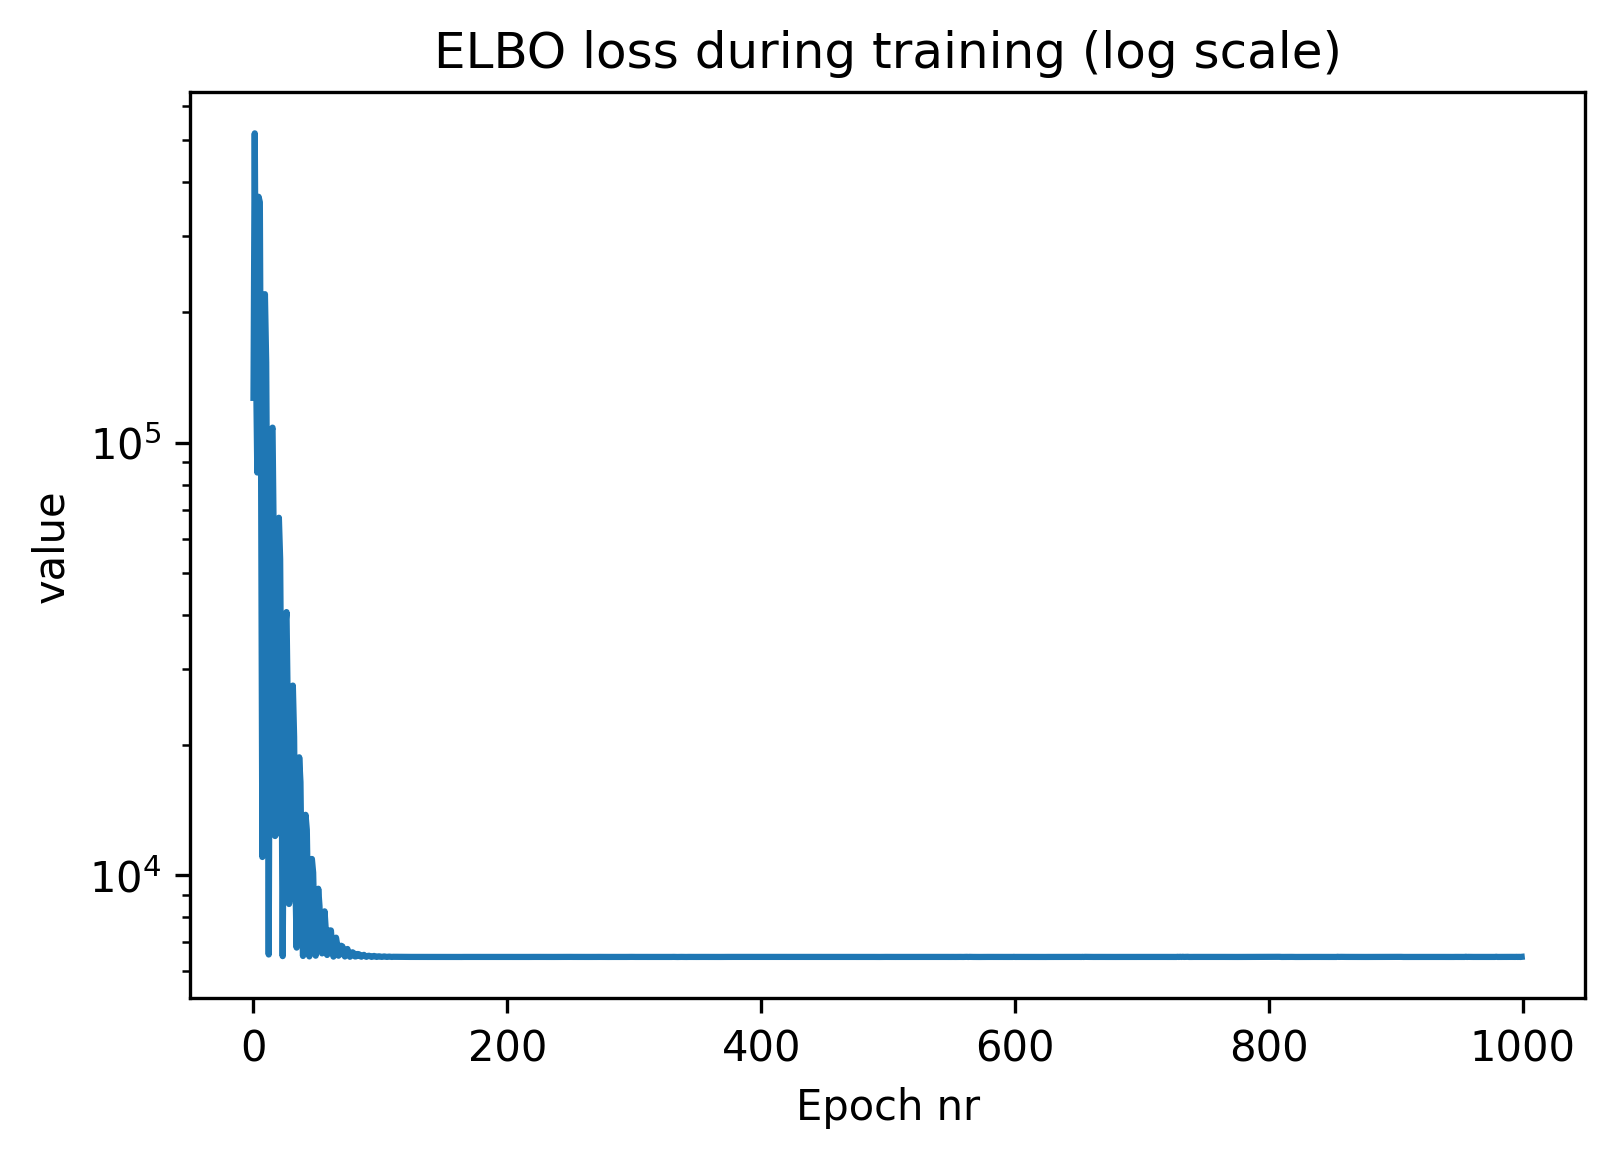

In [22]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


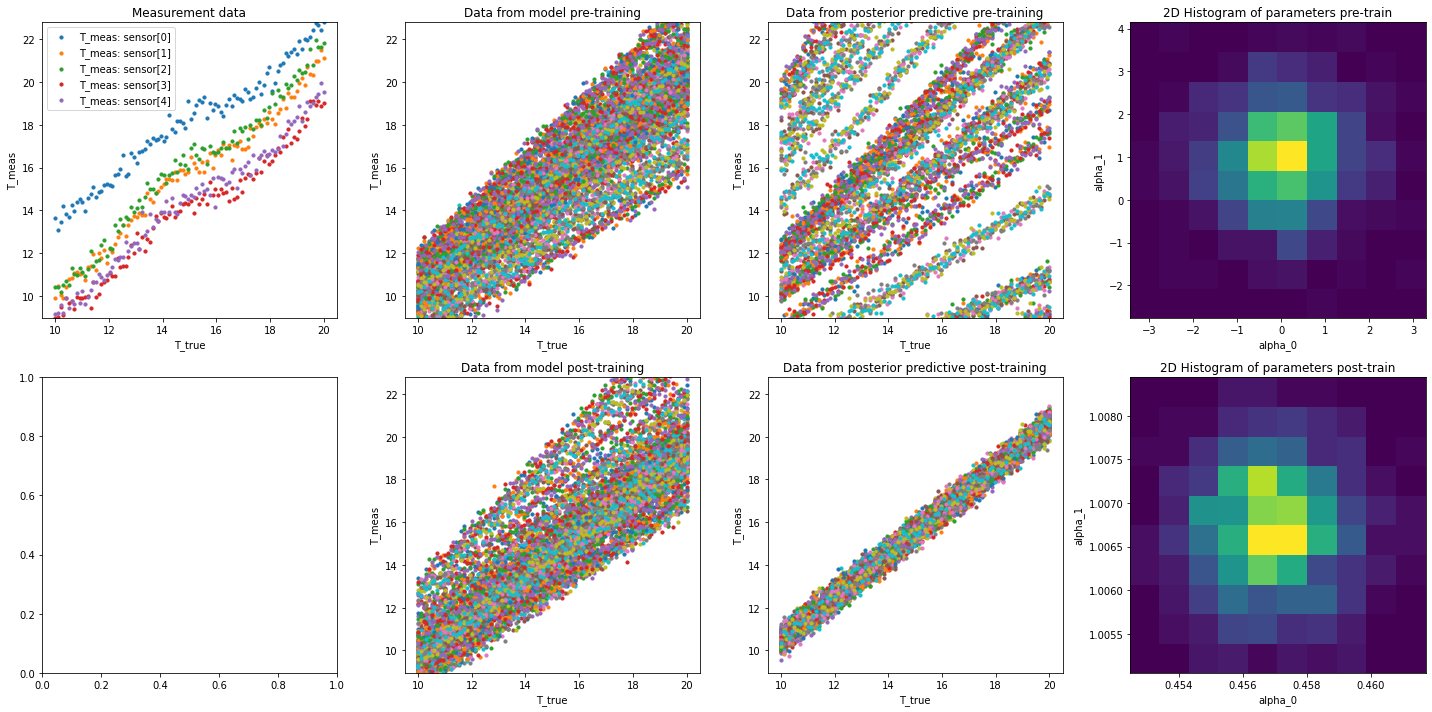

In [23]:

# ii) Compare model output and data

# Create the figure and 1x5 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# FIRST ROW
# First plot: measurement data
for i in range(n_device):
    axes[0,0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,0].set_title("Measurement data")
axes[0,0].set_xlabel("T_true")
axes[0,0].set_ylabel("T_meas")
axes[0,0].set_ylim(y_min, y_max)
axes[0,0].legend()

# Second plot: data produced by model pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,1].scatter(T_true[i,:], prior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,1].set_title("Data from model pre-training")
axes[0,1].set_xlabel("T_true")
axes[0,1].set_ylabel("T_meas")
axes[0,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,2].scatter(T_true[i,:], posterior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,2].set_title("Data from posterior predictive pre-training")
axes[0,2].set_xlabel("T_true")
axes[0,2].set_ylabel("T_meas")
axes[0,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide pre-training
axes[0,3].hist2d(posterior_pretrain[:,0].numpy(), posterior_pretrain[:,1].numpy(),
                 bins=10, cmap='viridis')
axes[0,3].set_title("2D Histogram of parameters pre-train")
axes[0,3].set_xlabel("alpha_0")
axes[0,3].set_ylabel("alpha_1")

# SECOND ROW
# Second plot: data produced by model post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,1].scatter(T_true[i,:], prior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,1].set_title("Data from model post-training")
axes[1,1].set_xlabel("T_true")
axes[1,1].set_ylabel("T_meas")
axes[1,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,2].scatter(T_true[i,:], posterior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,2].set_title("Data from posterior predictive post-training")
axes[1,2].set_xlabel("T_true")
axes[1,2].set_ylabel("T_meas")
axes[1,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide post-training
axes[1,3].hist2d(posterior_posttrain[:,0].numpy(), posterior_posttrain[:,1].numpy(),
                 bins=10, cmap='viridis')
axes[1,3].set_title("2D Histogram of parameters post-train")
axes[1,3].set_xlabel("alpha_0")
axes[1,3].set_ylabel("alpha_1")

plt.tight_layout()
plt.show()


# Note that here we illustrate multiple realizations of the model. We notice that
# after training the band of values considered possible has been shrinked down
# and especially the scale is known with much more certainty as assumed before.
    


---

## 🧾 Summary

In this notebook, we:

✅ Defined a linear model with **latent parameters** (scale and offset)  
✅ Used **priors** over those parameters and sampled them in the model  
✅ Built a **nontrivial guide** to approximate their posterior  
✅ Performed **Bayesian inference** using SVI with `num_particles > 1`  
✅ Compared **prior predictive**, **posterior predictive**, and **posterior** samples  
✅ Verified our results against a **closed-form posterior**

---

📌 In the next notebook, we'll introduce **hierarchical priors**, allowing each device to have its own scale and offset.  
This lets us model **inter-device variation** and learn shared structure via **Bayesian pooling**.
